Using device: cpu


a:\college\College_project\AI_project\Non-Uniform_Illumination\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
a:\college\College_project\AI_project\Non-Uniform_Illumination\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train samples: 8000 | Test samples: 2000


Baseline Epoch 1/3: 100%|██████████| 125/125 [00:09<00:00, 12.74it/s]


Loss: 2.3023


Baseline Epoch 2/3: 100%|██████████| 125/125 [00:11<00:00, 10.44it/s]


Loss: 2.3022


Baseline Epoch 3/3: 100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Loss: 2.3026
Baseline training done.

Epoch 1/3 Loss: 2.3026
Epoch 2/3 Loss: 2.2513
Epoch 3/3 Loss: 2.2171
NUI-Augmented robust training complete.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Baseline Model:
  Clean Test Accuracy: 10.00%
  NUI Test Accuracy:   10.00%
  Accuracy Drop:       0.00%

Robust Model (NUI-Augmented Training):
  Clean Test Accuracy: 17.00%
  NUI Test Accuracy:   17.30%
  Accuracy Increase on NUI: 7.30%


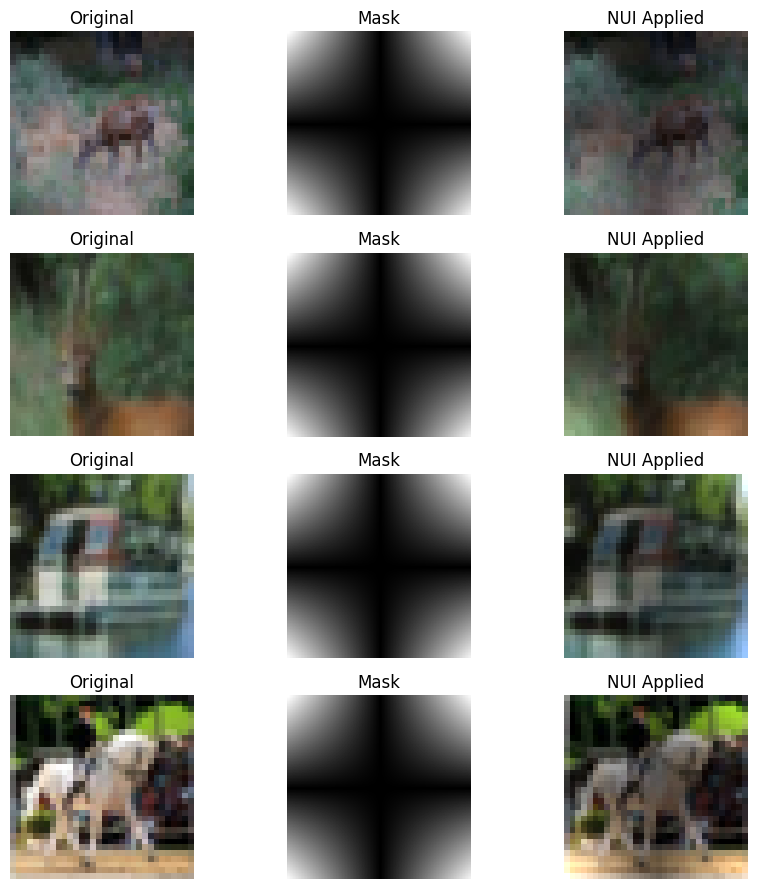

In [12]:
# ==============================================
# 1. Setup
# ==============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


# ==============================================
# 2. Strong NUI Mask Functions
# ==============================================
def generate_strong_nui_mask(h, w, strength=1.0):
    # Create coordinate grids
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    
    # Compute curved diamond shape
    center_x, center_y = w // 2, h // 2
    mask = np.abs(center_x - xx) * np.abs(center_y - yy)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0.1, 1.9).astype(np.float32)
    
    return mask


def apply_mask_to_tensor(img_tensor, mask):
    mask_tensor = torch.tensor(mask).unsqueeze(0).to(img_tensor.device)
    
    if mask_tensor.dim() == 3:
        mask_tensor = mask_tensor.unsqueeze(0)

    mask_tensor = F.interpolate(
        mask_tensor, size=img_tensor.shape[1:], mode='bilinear', align_corners=False
    ).squeeze(0)
    
    return img_tensor * mask_tensor

def apply_nui_to_img(img_tensor):
    h, w = img_tensor.shape[1], img_tensor.shape[2]
    mask = generate_strong_nui_mask(h, w)
    return apply_mask_to_tensor(img_tensor, mask)


# ==============================================
# 3. Load CIFAR-10 FULL Dataset (All Classes)
# ==============================================
import torch
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
import torchvision.transforms as T

transform = T.Compose([T.ToTensor()])


full_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

from torch.utils.data import ConcatDataset
full_dataset = ConcatDataset([full_dataset, test_dataset])  # 50k + 10k = 60k

# ===============================
#  Use only first 10k samples
# ===============================
subset_size = 10000
subset_dataset = Subset(full_dataset, list(range(subset_size)))

# ===============================
#  Split 80/20 → 8k train, 2k test
# ===============================
train_len = int(0.8 * subset_size)  # 8000
test_len = subset_size - train_len   # 2000

train_dataset, test_dataset = random_split(subset_dataset, [train_len, test_len])

# ===============================
# DataLoaders
# ===============================
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")



# ==============================================
# 4. Tiny CNN Model (SqueezeNet)
# ==============================================
import torchvision.models as models

class SqueezeNetCustom(nn.Module):
    def __init__(self, num_classes=10):  # FIX: 10 classes
        super().__init__()
        self.model = models.squeezenet1_1(pretrained=False)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)


# ==============================================
# 5. Evaluation Function
# ==============================================
def testing(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:

            labels = labels.to(device)  # FIX: no remapping

            if apply_nui:
                perturbed = []
                for img in imgs:
                    perturbed.append(apply_nui_to_img(img))
                imgs = torch.stack(perturbed)

            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


# ==============================================
# 6. Baseline Training (Clean Images)
# ==============================================
model_clean = SqueezeNetCustom(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_clean.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
    model_clean.train()
    running_loss = 0.0
    for imgs, labels in tqdm(trainloader, desc=f"Baseline Epoch {epoch+1}/{epochs}"):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_clean(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(trainloader):.4f}")
print("Baseline training done.\n")


# ==============================================
# 7. NUI-Augmented (Robust) Training
# ==============================================
def train_model_mixed(model, trainloader, optimizer, criterion, epochs, nui_ratio=0.8):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in trainloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            mask = torch.rand(len(imgs)) < nui_ratio
            imgs_aug = []
            for i, img in enumerate(imgs):
                if mask[i]:
                    imgs_aug.append(apply_nui_to_img(img))
                else:
                    imgs_aug.append(img)
            imgs_aug = torch.stack(imgs_aug)

            optimizer.zero_grad()
            outputs = model(imgs_aug)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Loss: {running_loss/len(trainloader):.4f}")


model_nui = SqueezeNetCustom(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nui.parameters(), lr=0.001)
train_model_mixed(model_nui, trainloader, optimizer, criterion, epochs, nui_ratio=0.5)
print("NUI-Augmented robust training complete.\n")


# ==============================================
# 8. Evaluate Robust Model
# ==============================================
acc_clean = testing(model_clean, testloader, apply_nui=False)
acc_nui   = testing(model_clean, testloader, apply_nui=True)

acc_clean_aug = testing(model_nui, testloader, apply_nui=False)
acc_nui_aug   = testing(model_nui, testloader, apply_nui=True)

acc_clean_pct     = acc_clean * 100
acc_nui_pct       = acc_nui * 100
acc_clean_aug_pct = acc_clean_aug * 100
acc_nui_aug_pct   = acc_nui_aug * 100

acc_clean_drop = acc_clean_pct - acc_nui_pct
print(f"Baseline Model:")
print(f"  Clean Test Accuracy: {acc_clean_pct:.2f}%")
print(f"  NUI Test Accuracy:   {acc_nui_pct:.2f}%")
print(f"  Accuracy Drop:       {acc_clean_drop:.2f}%\n")

acc_nui_increase = acc_nui_aug_pct - acc_nui_pct
robust_drop = acc_clean_aug_pct - acc_nui_aug_pct

print(f"Robust Model (NUI-Augmented Training):")
print(f"  Clean Test Accuracy: {acc_clean_aug_pct:.2f}%")
print(f"  NUI Test Accuracy:   {acc_nui_aug_pct:.2f}%")
print(f"  Accuracy Increase on NUI: {acc_nui_increase:.2f}%")


# ==============================================
# 9. Visualize Example NUI Effect
# ==============================================
def visualize_nui_effect(num_images=4):
    imgs, _ = next(iter(testloader))
    fig, axes = plt.subplots(num_images, 3, figsize=(9, 9))
    for i in range(num_images):
        img = imgs[i]
        mask = generate_strong_nui_mask(64, 64, strength=1.0)
        img_nui = apply_mask_to_tensor(img, mask)
        axes[i,0].imshow(img.permute(1,2,0)); axes[i,0].set_title("Original"); axes[i,0].axis("off")
        axes[i,1].imshow(mask, cmap="gray"); axes[i,1].set_title("Mask"); axes[i,1].axis("off")
        axes[i,2].imshow(img_nui.permute(1,2,0)); axes[i,2].set_title("NUI Applied"); axes[i,2].axis("off")
    plt.tight_layout()
    plt.show()

visualize_nui_effect()
